## 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

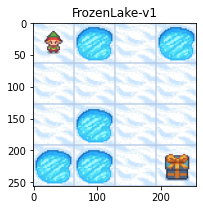

In [2]:
import gym
import time
import numpy as np
from gym.envs.toy_text.frozen_lake import generate_random_map

# 设置随机数种子
np.random.seed(233)

# 创建FrozenLake环境
env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=False, render_mode="rgb_array")

# 重置环境状态
env.reset()

# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env)

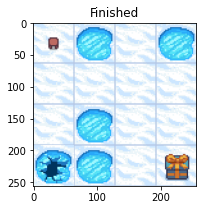

In [13]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 进行10步的游戏
for i in range(20):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过已经求得的Q值表，找到当前状态下的最优动作
    action = env.action_space.sample()
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
        
    time.sleep(0.5)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

## Dyna-Q算法

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

class DynaQ:
    """ Dyna-Q算法 """
    def __init__(self, env, epsilon, alpha, gamma, n_planning):
        self.n_action = env.action_space.n  # 动作个数
        self.n_space = env.observation_space.n # 环境状态个数
        self.Q_table = np.zeros([self.n_space, self.n_action])  # 初始化Q(s,a)表格
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.n_planning = n_planning  #执行Q-planning的次数,
        self.model = dict()  # 环境模型（存储历史样本）

    def choose_action(self, state):  # 选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, state, action, reward, next_state):
        td_error = reward + self.gamma * self.Q_table[next_state].max() - self.Q_table[state, action]
        self.Q_table[state, action] += self.alpha * td_error # 更新Q值

    def update(self, state, action, reward, next_state):
        self.q_learning(state, action, reward, next_state)
        self.model[(state, action)] = reward, next_state  # 将数据添加到模型中
        for n in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (state, action), (reward, next_state) = random.choice(list(self.model.items()))
            self.q_learning(state, action, reward, next_state)

In [5]:
# 超参数定义
num_episodes = 100  # 总回合数
epsilon = 0.01 # 以epsilon的概率随机选择动作
alpha = 0.1 # 学习率
gamma = 0.9 # 折扣因子
n_planning_list = [0, 2, 20] # planning step数

In [6]:
def DynaQ_FrozenLake(env, agent):
    # 记录每个回合的总奖励
    total_reward = []
    for i in range(num_episodes):
        # 当前回合的总奖励
        sum_reward = 0
        # 初始化环境并获取初始状态
        state, _ = env.reset()

        while True:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            # 判断是否达到终止状态
            done = terminated or truncated

            # 对于FrozenLake的佛系默认环境，适当调整奖励
            if 'FrozenLake' in env.spec.id:
                if terminated and reward == 1: # 游戏终止且reward为1表示到达终点，给予高额奖励
                    reward = 100
                elif terminated and reward == 0: # 游戏终止且reward为0表示掉进冰洞，给予反向奖励
                    reward = -100
                else: # 每走一步奖励为-1，其实是鼓励agent尽快完成任务
                    reward = -1
                    
            # 累加奖励
            sum_reward += reward  # 这里回报的计算不进行折扣因子衰减
            # 更新模型
            agent.update(state, action, reward, next_state)
            # 更新当前状态
            state = next_state
            if done:
                break
        total_reward.append(sum_reward)
    return total_reward

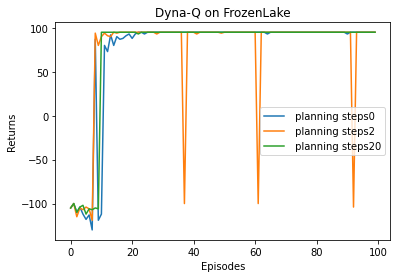

In [7]:
agent_list = []
for n_planning in n_planning_list:
    agent = DynaQ(env, epsilon, alpha, gamma, n_planning)
    total_reward = DynaQ_FrozenLake(env, agent)
    episodes_list = list(range(len(total_reward)))
    plt.plot(episodes_list, total_reward, label=' planning steps' + str(n_planning))
    agent_list.append(agent)
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('FrozenLake'))
plt.show()

# 训练结果

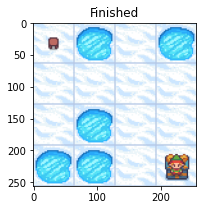

In [14]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env, figsize = (3, 3))

# 进行10步的游戏
for i in range(20):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过已经求得的Q值表，找到当前状态下的最优动作
    action = agent_list[2].choose_action(observation)
#     action = choose_action(observation, Q, epsilon = 0)
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
        
    time.sleep(0.5)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

In [9]:
agent_list[0].Q_table

array([[ -2.22178641,  48.7441804 , -10.        ,  -2.22178641],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        ,  -0.3444679 , -10.        ,  -0.29701   ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -1.65486239,  -1.60225471,  59.03816703,  -1.6931361 ],
       [ -1.10368866, -10.        ,  68.90700176, -10.        ],
       [  4.4912108 ,  78.70529234,  -0.42661   ,  -0.42742   ],
       [ -0.21439   ,   1.52      ,  -0.1       , -10.        ],
       [ -1.57056807, -10.        , -10.        ,  -1.6364538 ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        ,  -0.19      ,  88.92434743,  -0.1171    ],
       [  9.53311524,  99.99153585,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        ,  -0.1       ,  10.        ,   0.        ],
       [  0.        ,   0

In [10]:
np.array(["左", "下", "右", "上"])[np.argmax(agent_list[0].Q_table.reshape(4, 4, 4), axis = 2)]

array([['下', '左', '上', '左'],
       ['右', '右', '下', '下'],
       ['左', '左', '右', '下'],
       ['左', '左', '右', '左']], dtype='<U1')

In [11]:
np.array(["左", "下", "右", "上"])[np.argmax(agent_list[1].Q_table.reshape(4, 4, 4), axis = 2)]

array([['下', '左', '下', '左'],
       ['右', '右', '右', '下'],
       ['上', '左', '右', '下'],
       ['左', '左', '下', '左']], dtype='<U1')

In [12]:
np.array(["左", "下", "右", "上"])[np.argmax(agent_list[2].Q_table.reshape(4, 4, 4), axis = 2)]

array([['下', '左', '下', '左'],
       ['右', '右', '下', '下'],
       ['上', '左', '右', '下'],
       ['左', '左', '下', '左']], dtype='<U1')